**Importação das bibliotecas e leitura do dataset**

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (StratifiedKFold,
                                     StratifiedShuffleSplit,
                                     GridSearchCV)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, recall_score,
                             precision_score, f1_score)
from scipy.stats import wilcoxon

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/ML/Projeto Final/

depre = pd.read_csv('Depression Student Dataset.csv')
depre.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ML/Projeto Final


,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,28,2.0,4.0,7-8 hours,Moderate,Yes,9,2,Yes,No
1,Male,28,4.0,5.0,5-6 hours,Healthy,Yes,7,1,Yes,No
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,Yes,10,4,No,Yes
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,Yes,7,2,Yes,No
4,Female,31,1.0,5.0,More than 8 hours,Healthy,Yes,4,2,Yes,No


**Informações das features e verificação de dados faltantes**

In [171]:
depre.info()
print('\nDados Faltantes')
depre.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 502 non-null    object 
 1   Age                                    502 non-null    int64  
 2   Academic Pressure                      502 non-null    float64
 3   Study Satisfaction                     502 non-null    float64
 4   Sleep Duration                         502 non-null    object 
 5   Dietary Habits                         502 non-null    object 
 6   Have you ever had suicidal thoughts ?  502 non-null    object 
 7   Study Hours                            502 non-null    int64  
 8   Financial Stress                       502 non-null    int64  
 9   Family History of Mental Illness       502 non-null    object 
 10  Depression                             502 non-null    object 
dtypes: flo

,0
Gender,0
Age,0
Academic Pressure,0
Study Satisfaction,0
Sleep Duration,0
Dietary Habits,0
Have you ever had suicidal thoughts ?,0
Study Hours,0
Financial Stress,0
Family History of Mental Illness,0


**Divisão das features entre categóricas e numéricas**

In [172]:
numericas = ['Age', 'Academic Pressure', 'Study Satisfaction', 'Study Hours', 'Financial Stress']
categoricas = ['Gender', 'Sleep Duration', 'Dietary Habits',
               'Have you ever had suicidal thoughts ?',
               'Family History of Mental Illness']

**Remoção de dados para imputação posterior**

In [173]:
depre.loc[501, 'Depression'] = np.nan
depre.loc[0, 'Gender'] = np.nan
depre.loc[3, 'Have you ever had suicidal thoughts ?'] = np.nan
depre.loc[4, 'Family History of Mental Illness'] = np.nan
depre.loc[1, 'Sleep Duration'] = np.nan
depre.loc[2, 'Dietary Habits'] = np.nan

depre.head()
print('\nDados Faltantes')
depre.isnull().sum()


Dados Faltantes


,0
Gender,1
Age,0
Academic Pressure,0
Study Satisfaction,0
Sleep Duration,1
Dietary Habits,1
Have you ever had suicidal thoughts ?,1
Study Hours,0
Financial Stress,0
Family History of Mental Illness,1


**Imputação de dados faltantes com moda e mediana**

In [174]:
# Imputação por mediana para colunas numéricas
for col in numericas:
    depre[col].fillna(depre[col].median(), inplace=True)

# Imputação por moda para colunas categóricas
for col in categoricas:
    depre[col].fillna(depre[col].mode()[0], inplace=True)

# Imputação avulsa na classe
depre['Depression'] = depre['Depression'].replace(np.nan, 'No')

print('\nDados Faltantes')
depre.isnull().sum()


Dados Faltantes


<ipython-input-174-81a548186995>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  depre[col].fillna(depre[col].median(), inplace=True)
<ipython-input-174-81a548186995>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

,0
Gender,0
Age,0
Academic Pressure,0
Study Satisfaction,0
Sleep Duration,0
Dietary Habits,0
Have you ever had suicidal thoughts ?,0
Study Hours,0
Financial Stress,0
Family History of Mental Illness,0


**Distribuição da classe Depression**

Depression
No     251
Yes    251
Name: count, dtype: int64



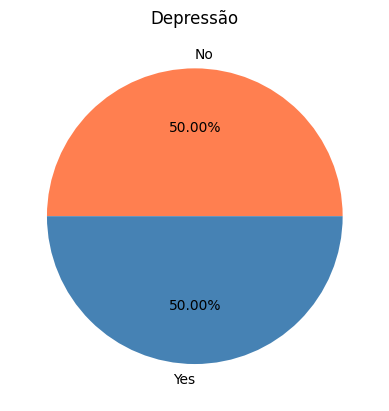

In [175]:
print(depre['Depression'].value_counts())
print()

depre['Depression'].value_counts().plot(kind='pie', autopct='%.2f%%', colors=['coral', 'steelblue'])
plt.title('Depressão')
plt.ylabel('')
plt.savefig('pizza_depression.png')
plt.show()

**EDA Univariada**

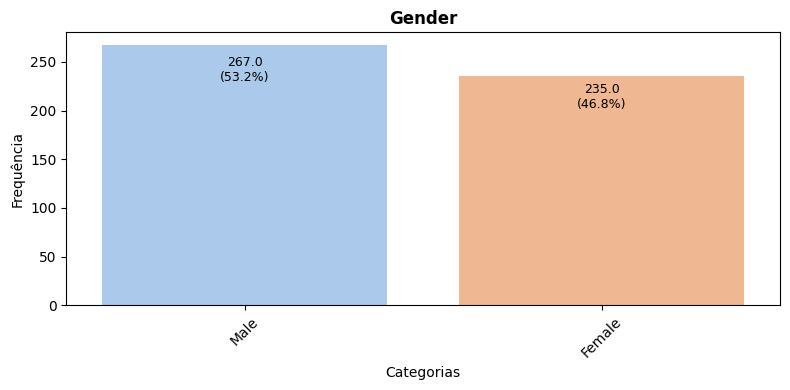

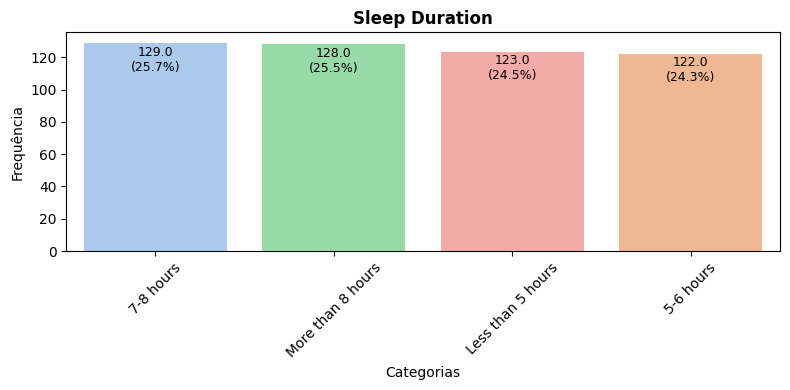

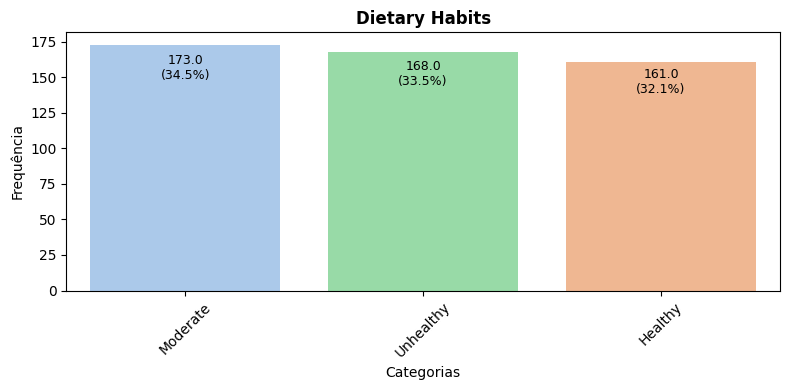

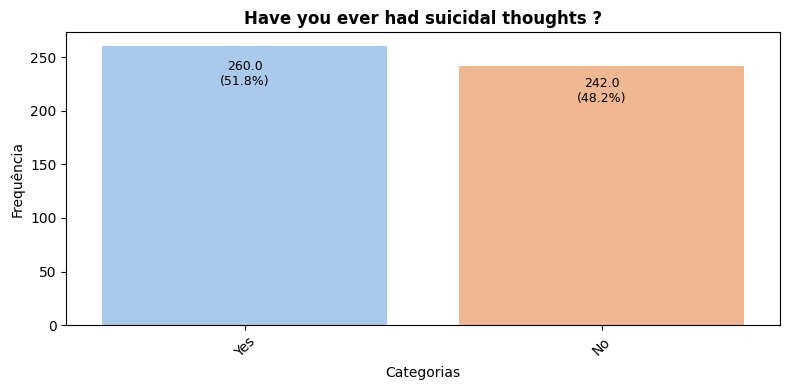

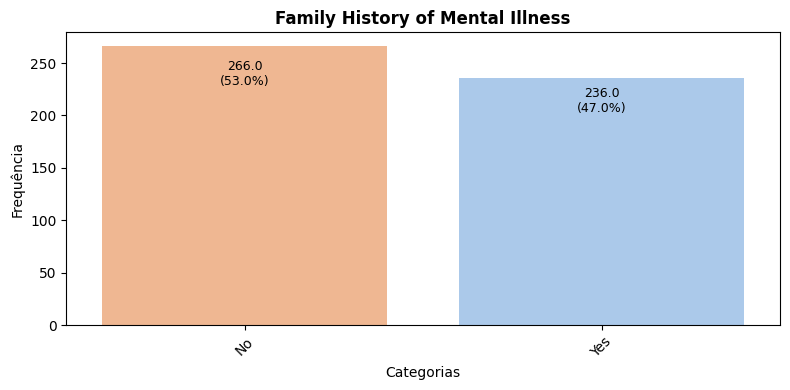

In [176]:
for coluna in categoricas:
    plt.figure(figsize=(8, 4)) # Uma figura para cada gráfico

    ax = sns.countplot(
        x=depre[coluna],
        palette='pastel',  # Paleta suave
        hue=depre[coluna],
        order=depre[coluna].value_counts().index  # Ordena pela frequência
    )

    plt.title(coluna, fontweight='bold')
    plt.xlabel('Categorias')
    plt.ylabel('Frequência')

    # Adiciona porcentagens nas barras
    total = len(depre[coluna])
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width()/2.,       # Posição X do texto
            y=height - (0.15 * height),           # Posição Y do texto
            s=f'{height}\n({height/total:.1%})',
            ha='center',
            va='bottom',
            fontsize=9
        )

    # Ajusta layout
    plt.xticks(rotation=45)  # Rotaciona labels longos
    plt.tight_layout()
    plt.savefig(f'countplot_{coluna}.png')
    plt.show()
    print('\n\n')

In [177]:
depre[numericas].describe()

,Age,Academic Pressure,Study Satisfaction,Study Hours,Financial Stress
count,502.000000,502.000000,502.000000,502.000000,502.000000
mean,26.241036,3.003984,3.075697,6.404382,2.928287
std,4.896501,1.390007,1.373490,3.742434,1.425053
min,18.000000,1.000000,1.000000,0.000000,1.000000
25%,22.000000,2.000000,2.000000,3.000000,2.000000
50%,26.500000,3.000000,3.000000,7.000000,3.000000
75%,30.000000,4.000000,4.000000,10.000000,4.000000
max,34.000000,5.000000,5.000000,12.000000,5.000000


**Pré-Processamento**

In [178]:
# Label encoding
depre['Depression'] = depre['Depression'].replace('No',False)
depre['Depression'] = depre['Depression'].replace('Yes',True)
depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('No',False)
depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('Yes',True)
depre['Family History of Mental Illness'] = depre['Family History of Mental Illness'].replace('No',False)
depre['Family History of Mental Illness'] = depre['Family History of Mental Illness'].replace('Yes',True)

# Convertendo float pra int nas numéricas ordinais
depre['Academic Pressure'] = depre['Academic Pressure'].astype(int)
depre['Study Satisfaction'] = depre['Study Satisfaction'].astype(int)

# One-hot encoding
depre = pd.get_dummies(depre, columns=['Gender', 'Sleep Duration', 'Dietary Habits'])

depre.head()

<ipython-input-178-8cc1f87f1879>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  depre['Depression'] = depre['Depression'].replace('Yes',True)
<ipython-input-178-8cc1f87f1879>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('Yes',True)
<ipython-input-178-8cc1f87f1879>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.in

,Age,Academic Pressure,Study Satisfaction,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression,Gender_Female,Gender_Male,Sleep Duration_5-6 hours,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Unhealthy
0,28,2,4,True,9,2,True,False,False,True,False,True,False,False,False,True,False
1,28,4,5,True,7,1,True,False,False,True,False,True,False,False,True,False,False
2,25,1,3,True,10,4,False,True,False,True,True,False,False,False,False,True,False
3,23,1,4,True,7,2,True,False,False,True,False,False,False,True,False,False,True
4,31,1,5,True,4,2,False,False,True,False,False,False,False,True,True,False,False


In [179]:
X = depre.drop('Depression', axis=1)
y = depre['Depression']

**Histograma**

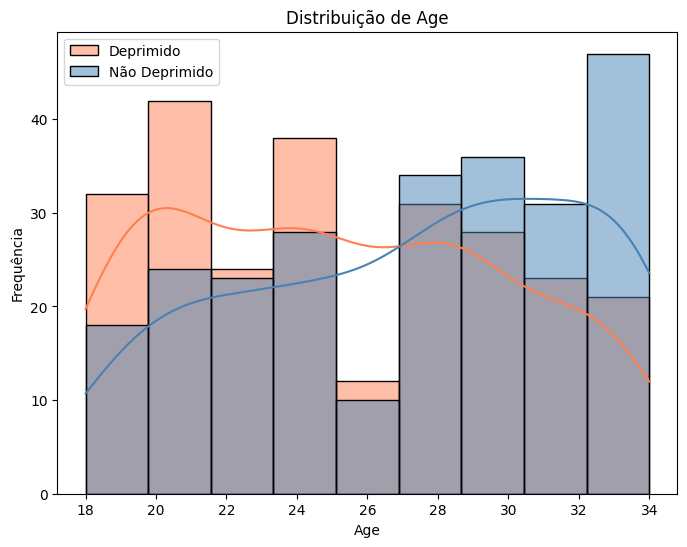

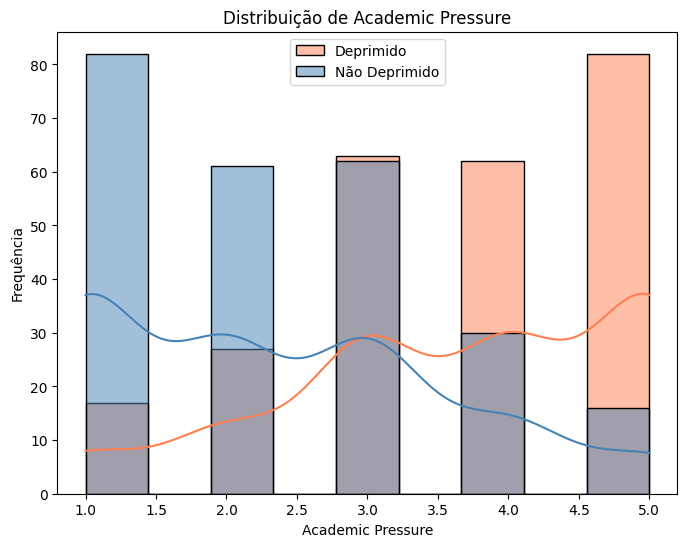

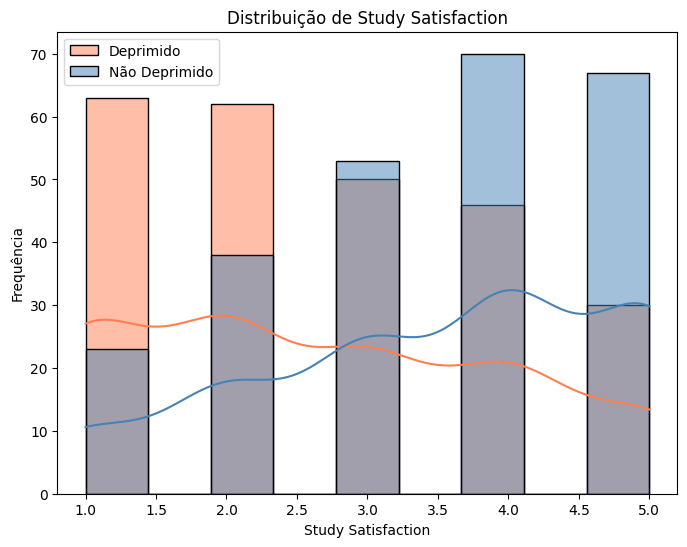

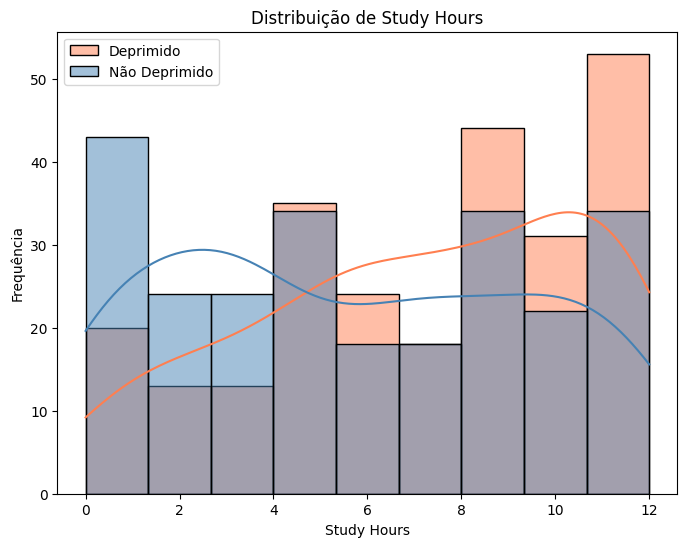

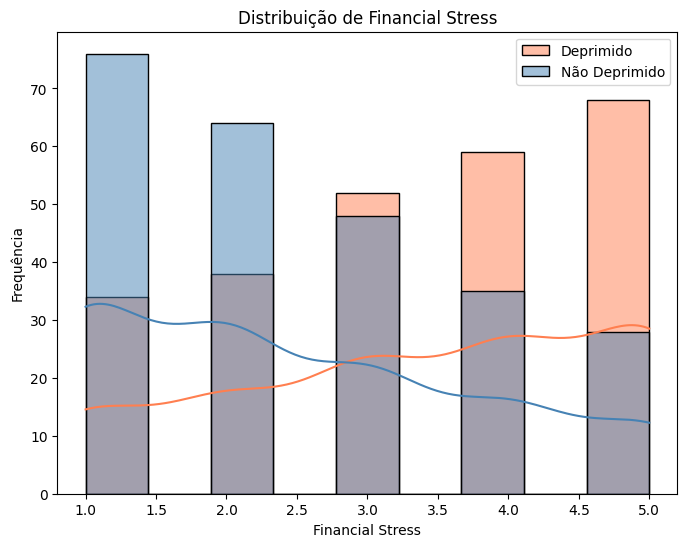

In [180]:
for coluna in numericas:
  plt.figure(figsize=(8, 6))
  sns.histplot(X[y == True][coluna], kde=True, label='Deprimido', color='coral')
  sns.histplot(X[y == False][coluna], kde=True, label='Não Deprimido', color='steelblue')
  plt.xlabel(coluna)
  plt.ylabel('Frequência')
  plt.title(f'Distribuição de {coluna}')
  plt.legend()
  plt.savefig(f'histograma_{coluna}.png')
  plt.show()
  print('\n\n')

**EDA Multivariada**

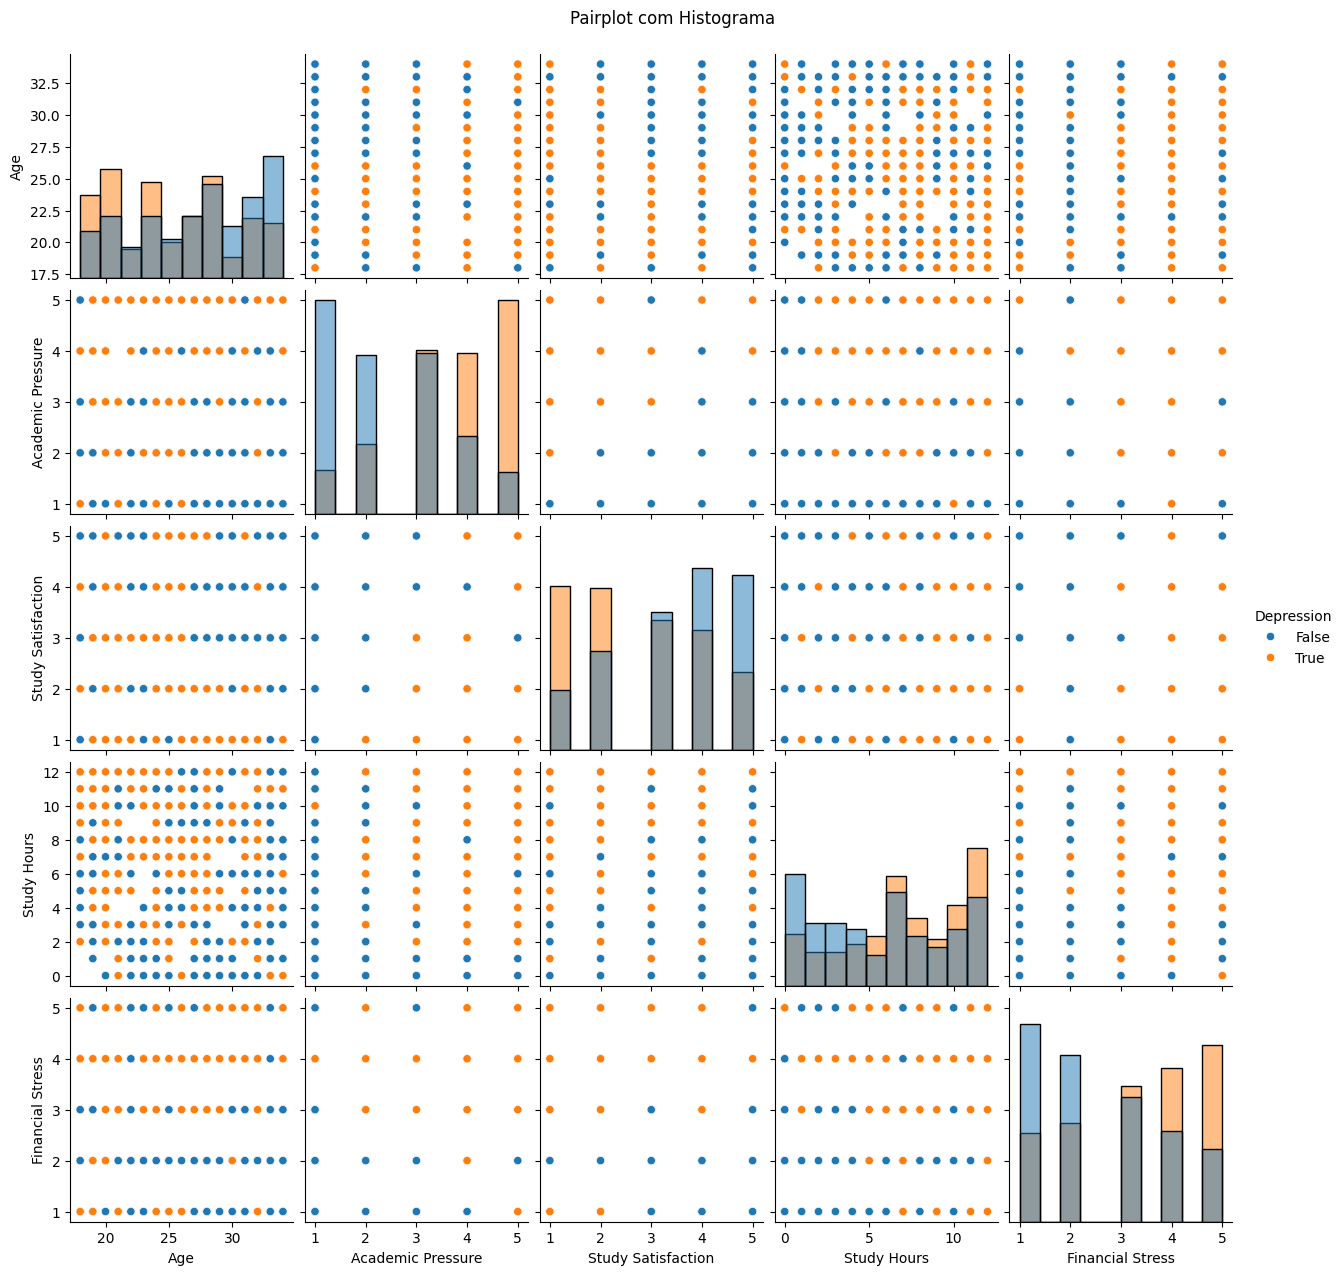

In [181]:
pp_hist = sns.pairplot(
    depre,
    vars=X[numericas],
    hue='Depression',
    diag_kind='hist'
)
plt.suptitle('Pairplot com Histograma', y=1.02)
plt.savefig('pairplot_hist.png', bbox_inches='tight')
plt.show()

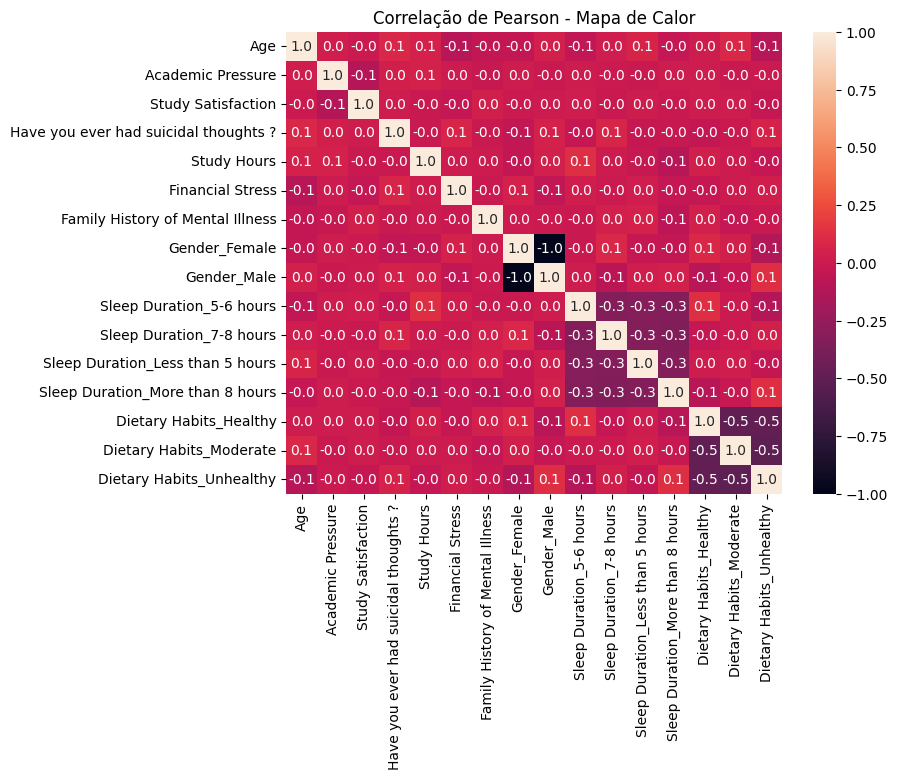

In [182]:
correlacao = X.corr(method='pearson')

plt.figure(figsize=(8, 6))  # Define o tamanho da figura
sns.heatmap(correlacao, annot=True, fmt='.1f')
plt.title('Correlação de Pearson - Mapa de Calor')
plt.savefig('correlação_heatmap.png')
plt.show()


Age - Depression False:
  Q1: 23.00, Q2: 28.00, Q3: 31.00
  Limite Inferior (LI): 11.00
  Limite Superior (LS): 43.00


Age - Depression True:
  Q1: 21.00, Q2: 25.00, Q3: 29.00
  Limite Inferior (LI): 9.00
  Limite Superior (LS): 41.00



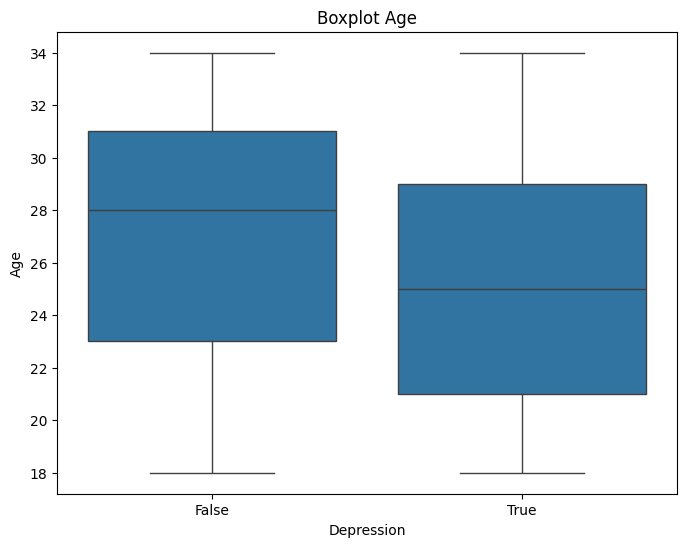


Academic Pressure - Depression False:
  Q1: 1.00, Q2: 2.00, Q3: 3.00
  Limite Inferior (LI): -2.00
  Limite Superior (LS): 6.00


Academic Pressure - Depression True:
  Q1: 3.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): 0.00
  Limite Superior (LS): 8.00



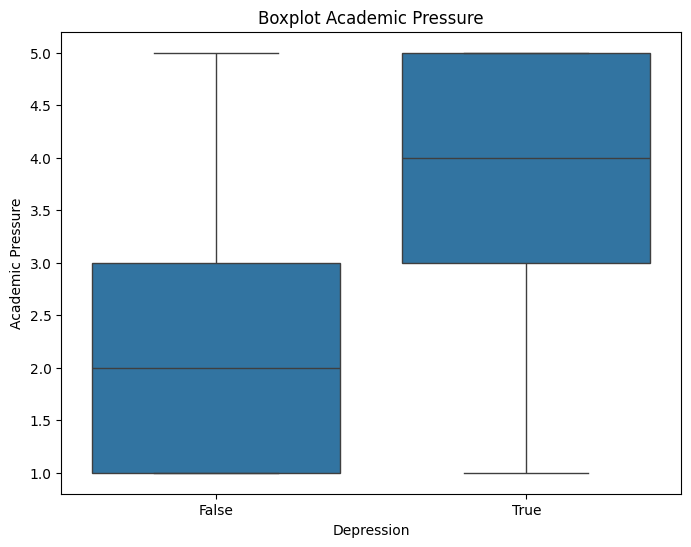


Study Satisfaction - Depression False:
  Q1: 3.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): 0.00
  Limite Superior (LS): 8.00


Study Satisfaction - Depression True:
  Q1: 1.50, Q2: 3.00, Q3: 4.00
  Limite Inferior (LI): -2.25
  Limite Superior (LS): 7.75



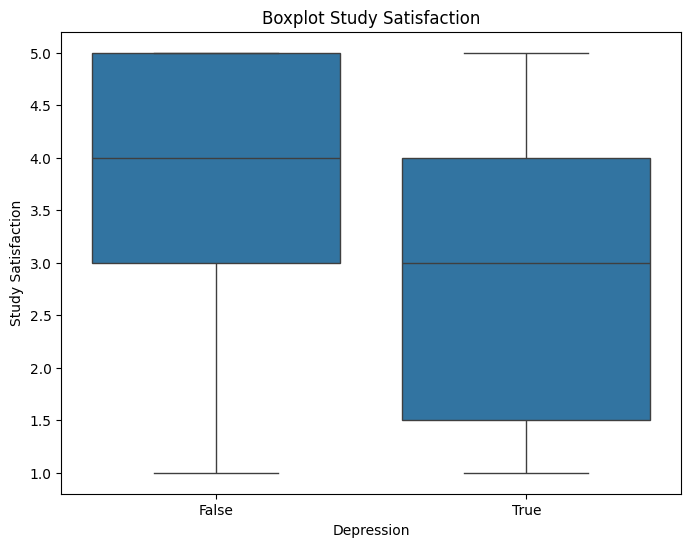


Study Hours - Depression False:
  Q1: 2.00, Q2: 6.00, Q3: 9.00
  Limite Inferior (LI): -8.50
  Limite Superior (LS): 19.50


Study Hours - Depression True:
  Q1: 5.00, Q2: 8.00, Q3: 10.00
  Limite Inferior (LI): -2.50
  Limite Superior (LS): 17.50



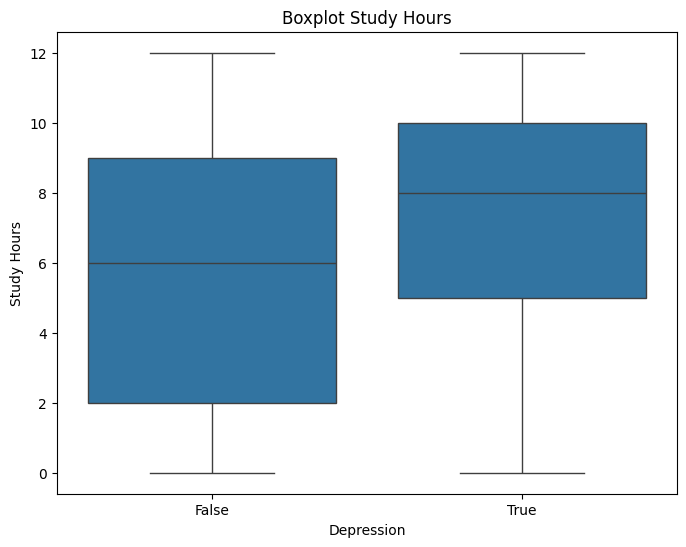


Financial Stress - Depression False:
  Q1: 1.00, Q2: 2.00, Q3: 3.50
  Limite Inferior (LI): -2.75
  Limite Superior (LS): 7.25


Financial Stress - Depression True:
  Q1: 2.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): -2.50
  Limite Superior (LS): 9.50



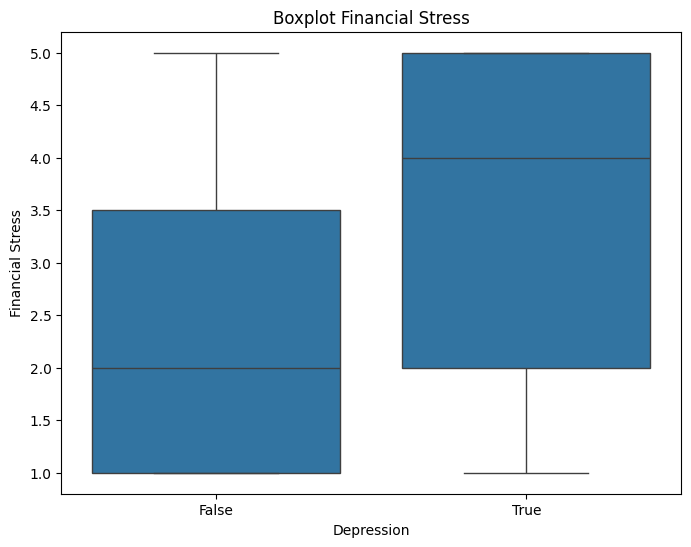

In [183]:
for feature in X[numericas]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=feature, data=X)
    plt.title(f'Boxplot {feature}')

    for class_label in sorted(y.unique()):
        Q1 = X[y == class_label][feature].quantile(0.25)
        Q2 = X[y == class_label][feature].median()
        Q3 = X[y == class_label][feature].quantile(0.75)
        IQR = Q3 - Q1
        LI = Q1 - 1.5 * IQR
        LS = Q3 + 1.5 * IQR

        print(f"\n{feature} - Depression {class_label}:")
        print(f"  Q1: {Q1:.2f}, Q2: {Q2:.2f}, Q3: {Q3:.2f}")
        print(f"  Limite Inferior (LI): {LI:.2f}")
        print(f"  Limite Superior (LS): {LS:.2f}\n")

    plt.savefig(f'boxplot_{feature.replace("/", "_")}.png')
    plt.show()

In [184]:
X = X.values

**Árvore de Decisão**

In [185]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define o cross-validation interno como 80% treino / 20% teste
inner_cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

parametros_tree = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12],  # Profundidade máxima da árvore
    'criterion': ['gini', 'entropy']                # Critério de divisão
}

# Listas para armazenar as métricas
test_scores = []
best_params = []

fold = 0

for train_index, test_index in kf.split(X, y):  # Iteração das folds
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Normalização Min-Max
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)  # Ajusta e transforma o treino
    X_test = scaler.transform(X_test)        # Transforma o teste

    # Grid Search
    grid_search = GridSearchCV(
        DecisionTreeClassifier(class_weight='balanced', random_state=42),
        parametros_tree,
        cv=inner_cv,
        scoring='recall', # Falsos Negativos como prioridade
        refit=True        # Re-treina o melhor modelo com todos os dados de treino
    )
    grid_search.fit(X_train, y_train)

    best_tree = grid_search.best_estimator_
    best_params.append(grid_search.best_params_)

    y_pred = best_tree.predict(X_test)
    test_scores.append({
        'acuracia': accuracy_score(y_test, y_pred),
        'precisao': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    })

    print("\nFold", fold + 1)
    print(f"Acurácia: {test_scores[-1]['acuracia']:.2f}")
    print(f"Precisão: {test_scores[-1]['precisao']:.2f}")
    print(f"Recall: {test_scores[-1]['recall']:.2f}")
    print(f"F1-Score: {test_scores[-1]['f1']:.2f}")
    print("\n"+"-"*20)
    fold += 1

# Métricas finais com desvio padrão
print("\nMétricas Finais")
print(f"Acurácia: {np.mean([s['acuracia'] for s in test_scores]):.2f} ± {np.std([s['acuracia'] for s in test_scores]):.2f}")
print(f"Precisão: {np.mean([s['precisao'] for s in test_scores]):.2f} ± {np.std([s['precisao'] for s in test_scores]):.2f}")
print(f"Recall: {np.mean([s['recall'] for s in test_scores]):.2f} ± {np.std([s['recall'] for s in test_scores]):.2f}")
print(f"F1-Score: {np.mean([s['f1'] for s in test_scores]):.2f} ± {np.std([s['f1'] for s in test_scores]):.2f}")
print("\nMelhores parâmetros encontrados")
for i, params in enumerate(best_params):
    print(f"Fold {i+1}: {params}")


Fold 1
Acurácia: 0.82
Precisão: 0.83
Recall: 0.80
F1-Score: 0.82

--------------------

Fold 2
Acurácia: 0.82
Precisão: 0.76
Recall: 0.96
F1-Score: 0.85

--------------------

Fold 3
Acurácia: 0.84
Precisão: 0.87
Recall: 0.80
F1-Score: 0.83

--------------------

Fold 4
Acurácia: 0.80
Precisão: 0.76
Recall: 0.88
F1-Score: 0.81

--------------------

Fold 5
Acurácia: 0.84
Precisão: 0.87
Recall: 0.80
F1-Score: 0.83

--------------------

Fold 6
Acurácia: 0.70
Precisão: 0.66
Recall: 0.84
F1-Score: 0.74

--------------------

Fold 7
Acurácia: 0.78
Precisão: 0.72
Recall: 0.92
F1-Score: 0.81

--------------------

Fold 8
Acurácia: 0.76
Precisão: 0.76
Recall: 0.76
F1-Score: 0.76

--------------------

Fold 9
Acurácia: 0.90
Precisão: 0.95
Recall: 0.84
F1-Score: 0.89

--------------------

Fold 10
Acurácia: 0.84
Precisão: 0.87
Recall: 0.80
F1-Score: 0.83

--------------------

Métricas Finais
Acurácia: 0.81 ± 0.05
Precisão: 0.80 ± 0.08
Recall: 0.84 ± 0.06
F1-Score: 0.82 ± 0.04

Melhores parâme

In [186]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define o cross-validation interno como 80% treino / 20% teste
inner_cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

parametros_tree = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12],  # Profundidade máxima da árvore
    'criterion': ['gini', 'entropy']                # Critério de divisão
}

# Listas para armazenar as métricas
test_scores = []
best_params = []

fold = 0

for train_index, test_index in kf.split(X, y):  # Iteração das folds
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Padronização Standard Scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Ajusta e transforma o treino
    X_test = scaler.transform(X_test)        # Transforma o teste

    # Grid Search
    grid_search = GridSearchCV(
        DecisionTreeClassifier(class_weight='balanced', random_state=42),
        parametros_tree,
        cv=inner_cv,
        scoring='recall', # Falsos Negativos como prioridade
        refit=True        # Re-treina o melhor modelo com todos os dados de treino
    )
    grid_search.fit(X_train, y_train)

    best_tree = grid_search.best_estimator_
    best_params.append(grid_search.best_params_)

    y_pred = best_tree.predict(X_test)
    test_scores.append({
        'acuracia': accuracy_score(y_test, y_pred),
        'precisao': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    })

    print("\nFold", fold + 1)
    print(f"Acurácia: {test_scores[-1]['acuracia']:.2f}")
    print(f"Precisão: {test_scores[-1]['precisao']:.2f}")
    print(f"Recall: {test_scores[-1]['recall']:.2f}")
    print(f"F1-Score: {test_scores[-1]['f1']:.2f}")
    print("\n"+"-"*20)
    fold += 1

# Métricas finais com desvio padrão
print("\nMétricas Finais")
print(f"Acurácia: {np.mean([s['acuracia'] for s in test_scores]):.2f} ± {np.std([s['acuracia'] for s in test_scores]):.2f}")
print(f"Precisão: {np.mean([s['precisao'] for s in test_scores]):.2f} ± {np.std([s['precisao'] for s in test_scores]):.2f}")
print(f"Recall: {np.mean([s['recall'] for s in test_scores]):.2f} ± {np.std([s['recall'] for s in test_scores]):.2f}")
print(f"F1-Score: {np.mean([s['f1'] for s in test_scores]):.2f} ± {np.std([s['f1'] for s in test_scores]):.2f}")
print("\nMelhores parâmetros encontrados")
for i, params in enumerate(best_params):
    print(f"Fold {i+1}: {params}")


Fold 1
Acurácia: 0.82
Precisão: 0.83
Recall: 0.80
F1-Score: 0.82

--------------------

Fold 2
Acurácia: 0.82
Precisão: 0.76
Recall: 0.96
F1-Score: 0.85

--------------------

Fold 3
Acurácia: 0.84
Precisão: 0.87
Recall: 0.80
F1-Score: 0.83

--------------------

Fold 4
Acurácia: 0.80
Precisão: 0.76
Recall: 0.88
F1-Score: 0.81

--------------------

Fold 5
Acurácia: 0.84
Precisão: 0.87
Recall: 0.80
F1-Score: 0.83

--------------------

Fold 6
Acurácia: 0.70
Precisão: 0.66
Recall: 0.84
F1-Score: 0.74

--------------------

Fold 7
Acurácia: 0.78
Precisão: 0.72
Recall: 0.92
F1-Score: 0.81

--------------------

Fold 8
Acurácia: 0.76
Precisão: 0.76
Recall: 0.76
F1-Score: 0.76

--------------------

Fold 9
Acurácia: 0.86
Precisão: 0.88
Recall: 0.84
F1-Score: 0.86

--------------------

Fold 10
Acurácia: 0.84
Precisão: 0.87
Recall: 0.80
F1-Score: 0.83

--------------------

Métricas Finais
Acurácia: 0.81 ± 0.05
Precisão: 0.80 ± 0.07
Recall: 0.84 ± 0.06
F1-Score: 0.81 ± 0.04

Melhores parâme